# Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import vis
from model.bayesObs import BayesianObserver
from scipy.stats import pearsonr
from scipy.optimize import minimize
from sklearn.metrics import r2_score
from funcs.pixTrans import pix2ang
from funcs.modelComp import AICMet, BICMet

# Load Data

In [18]:
# Get Subject Name

figPath      = r'F:\#2 MS Projects\Ongoing\timePerception\analysis\Modeling\Results\Figures'
subjectsPath = r'F:\#2 MS Projects\Ongoing\timePerception\analysis\Data'
subInfoPath  = r'F:\#2 MS Projects\Ongoing\timePerception\dataInfo\input'
subjectNames = os.listdir(subjectsPath) 

print(f"[0]: Average Over All Subjects")
for iterator, name in enumerate(subjectNames):
    print(f"[{iterator + 1}]: {name}")

idx = input()
if (idx != '0'):
    subjectName = subjectNames[int(idx) - 1]
else:
    subjectName = 'All'

# Load Data

exclude = ['KiomarsSharifi']
if (subjectName == 'All'):
    tmpTime  = []
    tmpSpace = []  
    for iterator, name in enumerate(subjectNames):
        if (name in exclude):
            continue
        if (os.path.isfile(os.path.join(subjectsPath, name, name+'_timeData.csv'))):
            timeTable  = pd.read_csv(os.path.join(subjectsPath, name, name+'_timeData.csv'))
            tmpTime.append(timeTable)
        if (os.path.isfile(os.path.join(subjectsPath, name, name+'_spaceData.csv'))):
            spaceTable = pd.read_csv(os.path.join(subjectsPath, name, name+'_spaceData.csv'))
            tmpSpace.append(spaceTable)
    timeTable  = pd.concat(tmpTime, axis=0, ignore_index=True)
    spaceTable = pd.concat(tmpSpace, axis=0, ignore_index=True)
else: 
    subjectDataPath = os.path.join(subjectsPath, subjectName)
    timeTable       = pd.read_csv(os.path.join(subjectDataPath, subjectName+'_timeData.csv'))
    spaceTable      = pd.read_csv(os.path.join(subjectDataPath, subjectName+'_spaceData.csv'))
 
print(f"\nFilter?\nYes: 1")
filter = input()

print(f"Logtransform?\nYes: 1")
transform = input()

# Make Directory

subjectFigPath = os.path.join(figPath, subjectName)
if not os.path.exists(subjectFigPath):
    os.mkdir(subjectFigPath)

# Transform Distances

spaceTable['prodDist_1'] = spaceTable['prodDist_1'].apply(lambda x: pix2ang(x, 600, 0.276))

if transform == '1':
    nCons = .01
    timeTable.RT           = np.log(1 + (timeTable.RT / nCons))
    timeTable.timeInterval = np.log(1 + (timeTable.timeInterval / nCons))

    spaceTable.prodDist_1   = np.log(1 + (spaceTable.prodDist_1 / nCons))
    spaceTable.distInterval = np.log(1 + (spaceTable.distInterval / nCons))

    timeInts = (np.exp(np.unique(timeTable['timeInterval'])) - 1) / (1 / nCons)
    distInts = (np.exp(np.unique(spaceTable['distInterval'])) - 1) / (1 / nCons)

[0]: Average Over All Subjects
[1]: AliHajian
[2]: KiomarsSharifi
[3]: MehdiSanayei
[4]: MiladYekani
[5]: MobinAdli
[6]: MobinaKhosravi
[7]: ParisaShadmehr
[8]: SepehrSima
[9]: SoodehMajidpour



Filter?
Yes: 1
Logtransform?
Yes: 1


## Trim Data

In [19]:
Q1Time  = timeTable['RT'].quantile(.25)
Q3Time  = timeTable['RT'].quantile(.75)
IQRTime = Q3Time - Q1Time

Q1Space  = spaceTable['prodDist_1'].quantile(.25)
Q3Space  = spaceTable['prodDist_1'].quantile(.75)
IQRSpace = Q3Space - Q1Space

if (filter == '1'):
    timeTable = timeTable.query('(@Q1Time - 1.5 * @IQRTime) <= RT <= (@Q3Time + 1.5 * @IQRTime)')
    spaceTable = spaceTable.query('(@Q1Space - 1.5 * @IQRSpace) <= prodDist_1 <= (@Q3Space + 1.5 * @IQRSpace)')
    spaceTable = spaceTable.query('RT > .2')

## Define Inputs

In [20]:
initialValues   = np.array([0.3, 0.3, 0.8])
integSteps      = 1000
timeIntegRange  = [0.001, 10]
spaceIntegRange = [0.001, 16]
estimType       = ['BLS', 'MAP', 'MLE']

tSvec           = np.array(timeTable['timeInterval'])
tPvec           = np.array(timeTable['RT'])
minTimeR        = np.min(timeTable['timeInterval'])
maxTimeR        = np.max(timeTable['timeInterval'])

groupTime       = timeTable.groupby(['timeIntervalType']).RT.apply(list)
groupTime       = [np.array(groupTime[2]), np.array(groupTime[0]), np.array(groupTime[1])]
timeInts        = np.unique(timeTable['timeInterval'])

dSvec           = np.array(spaceTable['distInterval'])
dPvec           = np.array(spaceTable['prodDist_1'])
minSpaceR       = np.min(spaceTable['distInterval'])
maxSpaceR       = np.max(spaceTable['distInterval'])

groupSpace      = spaceTable.groupby("distIntervalType")["prodDist_1"].apply(list)
groupSpace      = [np.array(groupSpace[2]), np.array(groupSpace[0]), np.array(groupSpace[1])]
distInts        = np.unique(spaceTable['distInterval'])

## Load Subjects' Information

In [6]:
subInfoInput = pd.read_csv(os.path.join(subInfoPath, 'subInfo.csv'))
subInfoInput

,name,ID,age,gender,handedness,firstBlocks,lineLoc,lineOr,AIC_BLS_Space,AIC_MAP_Space,...,timeWm_MLE,spaceWm_BLS,spaceWm_MAP,spaceWm_MLE,timeWp_BLS,spaceWp_BLS,timeWp_MAP,spaceWp_MAP,timeWp_MLE,spaceWp_MLE
0,SepehrSima,1,23,M,R,time,right,up,1723.961544,1697.692723,...,0.002862,0.028952,0.157583,0.252126,0.233586,0.249585,0.489834,0.233538,0.560359,0.001332
1,MehdiSanayei,2,40,M,R,space,left,up,1787.866281,1779.493514,...,0.196491,0.025980,0.001957,0.027377,0.270269,0.255659,0.239316,0.254041,0.363905,0.251863
2,KiomarsSharifi,3,28,M,R,time,right,up,1781.222723,1783.372020,...,0.002868,0.039046,0.018793,0.002258,0.466312,0.333881,0.824103,0.337040,0.864551,0.337774
3,MobinAdli,4,23,M,R,space,right,up,1375.905153,1360.956861,...,0.227883,0.059548,0.163968,0.271078,0.356510,0.256364,0.619502,0.241312,0.680510,0.042972
4,AliHajian,5,21,M,L,time,left,down,1596.619898,1574.046984,...,0.102428,0.026013,0.133449,0.224170,0.350739,0.217332,0.394053,0.203719,0.422924,0.007077
5,MiladYekani,6,35,M,R,space,left,down,1787.226357,1793.712899,...,0.210539,0.060273,0.049484,0.002367,0.267818,0.283248,0.371449,0.288161,0.444723,0.293280
6,MobinaKhosravi,7,21,F,R,time,right,down,1729.341235,1704.530448,...,0.138646,0.025980,0.145714,0.246779,0.314735,0.242249,0.407107,0.229117,0.455288,0.040641
7,SoodehMajidpour,8,34,F,R,space,right,down,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,ParisaShadmehr,9,23,F,R,time,left,up,13330.368316,13239.253839,...,0.175536,0.030915,0.119735,0.228192,0.330837,0.247858,0.468639,0.235365,0.534869,0.111933


# Modeling for Time Estimation

In [21]:
# Fit

for timeEstim in estimType:
    bnds   = ((0.001, None), (0.001, None), (0.001, None))
    model  = BayesianObserver(tSvec, tPvec, minTimeR, maxTimeR, integSteps, timeIntegRange, timeEstim)
    res    = minimize(model.BayesianModel, initialValues, bounds=bnds,
                      method='Nelder-Mead', options={'gtol': 1e-6, 'disp': True})
    if timeEstim == 'BLS':
        timeNLL_BLS = model.BayesianModel([res.x[0], res.x[1], res.x[2]])
        w_mTime_BLS = res.x[0]
        w_pTime_BLS = res.x[1]
        facTime_BLS = res.x[2]
    elif timeEstim == 'MAP':
        timeNLL_MAP = model.BayesianModel([res.x[0], res.x[1], res.x[2]])
        w_mTime_MAP = res.x[0]
        w_pTime_MAP = res.x[1]
        facTime_MAP = res.x[2]
    elif timeEstim == 'MLE':
        timeNLL_MLE = model.BayesianModel([res.x[0], res.x[1], res.x[2]])
        w_mTime_MLE = res.x[0]
        w_pTime_MLE = res.x[1]    
        facTime_MLE = res.x[2]

# Simulate

for timeEstim in estimType:
    model  = BayesianObserver(tSvec, tPvec, minTimeR, maxTimeR, integSteps, timeIntegRange, timeEstim)
    if timeEstim == 'BLS':
        tmpTime_BLS = [w_mTime_BLS, w_pTime_BLS, facTime_BLS]
        simTime_BLS = model.BayesSimulation(tmpTime_BLS, 100)
    elif timeEstim == 'MAP':
        tmpTime_MAP = [w_mTime_MAP, w_pTime_MAP, facTime_MAP]
        simTime_MAP = model.BayesSimulation(tmpTime_MAP, 100)
    elif timeEstim == 'MLE':
        tmpTime_MLE = [w_mTime_MLE, w_pTime_MLE, facTime_MLE]
        simTime_MLE = model.BayesSimulation(tmpTime_MLE, 100)


if transform == '1':
    for timeEstim in estimType:
        if timeEstim == 'BLS':
            simTimeTrans_BLS = [np.array([(np.exp(x) - 1) / (1 / nCons) for x in t]) for t in simTime_BLS]
        elif timeEstim == 'MAP':
            simTimeTrans_MAP = [np.array([(np.exp(x) - 1) / (1 / nCons) for x in t]) for t in simTime_MAP]
        elif timeEstim == 'MLE':
            simTimeTrans_MLE = [np.array([(np.exp(x) - 1) / (1 / nCons) for x in t]) for t in simTime_MLE]
else:
    simTimeTrans_BLS = simTime_BLS
    simTimeTrans_MAP = simTime_MAP
    simTimeTrans_MLE = simTime_MLE

simTimeTrans_BLS = [simTimeTrans_BLS[1][np.where(simTimeTrans_BLS[0] == num)[0]] for num in np.unique(simTimeTrans_BLS[0])]
muTimeTrans_BLS  = [np.mean(x) for x in simTimeTrans_BLS]
siTimeTrans_BLS  = [np.std(x) for x in simTimeTrans_BLS]

simTimeTrans_MAP = [simTimeTrans_MAP[1][np.where(simTimeTrans_MAP[0] == num)[0]] for num in np.unique(simTimeTrans_MAP[0])]
muTimeTrans_MAP  = [np.mean(x) for x in simTimeTrans_MAP]
siTimeTrans_MAP  = [np.std(x) for x in simTimeTrans_MAP]

simTimeTrans_MLE = [simTimeTrans_MLE[1][np.where(simTimeTrans_MLE[0] == num)[0]] for num in np.unique(simTimeTrans_MLE[0])]
muTimeTrans_MLE  = [np.mean(x) for x in simTimeTrans_MLE]
siTimeTrans_MLE  = [np.std(x) for x in simTimeTrans_MLE]


C:\Users\sepeh\AppData\Local\Temp\ipykernel_15416\2618005112.py:6: OptimizeWarning: Unknown solver options: gtol
  res    = minimize(model.BayesianModel, initialValues, bounds=bnds,


Optimization terminated successfully.
         Current function value: 98.783654
         Iterations: 68
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: 176.332769
         Iterations: 65
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: 221.681599
         Iterations: 57
         Function evaluations: 106


# Modeling for Distance Estimation

In [99]:
facSpace_BLS

1.095699954202582

In [98]:
facTime_BLS

0.9312063983937027

In [22]:
# Fit

for spaceEstim in estimType:
    bnds   = ((0.0001, None), (0.0001, None), (0.0001, None))
    model  = BayesianObserver(dSvec, dPvec, minSpaceR, maxSpaceR, integSteps, spaceIntegRange, spaceEstim)
    res    = minimize(model.BayesianModel, initialValues, bounds=bnds,
                      method='Nelder-Mead', options={'gtol': 1e-6, 'disp': True})
    if spaceEstim == 'BLS':
        spaceNLL_BLS = model.BayesianModel([res.x[0], res.x[1], res.x[2]])
        w_mSpace_BLS = res.x[0]
        w_pSpace_BLS = res.x[1]
        facSpace_BLS = res.x[2]
    elif spaceEstim == 'MAP':
        spaceNLL_MAP = model.BayesianModel([res.x[0], res.x[1], res.x[2]])
        w_mSpace_MAP = res.x[0]
        w_pSpace_MAP = res.x[1]
        facSpace_MAP = res.x[2]
    elif spaceEstim == 'MLE':
        spaceNLL_MLE = model.BayesianModel([res.x[0], res.x[1], res.x[2]])
        w_mSpace_MLE = res.x[0]
        w_pSpace_MLE = res.x[1]    
        facSpace_MLE = res.x[2]

# Simulate

for spaceEstim in estimType:
    model  = BayesianObserver(dSvec, dPvec, minSpaceR, maxSpaceR, integSteps, spaceIntegRange, spaceEstim)
    if spaceEstim == 'BLS':
        tmpSpace_BLS = [w_mSpace_BLS, w_pSpace_BLS, facSpace_BLS]
        simSpace_BLS = model.BayesSimulation(tmpSpace_BLS, 100)
    elif spaceEstim == 'MAP':
        tmpSpace_MAP = [w_mTime_MAP, w_pTime_MAP, facSpace_MAP]
        simSpace_MAP = model.BayesSimulation(tmpSpace_MAP, 100)
    elif spaceEstim == 'MLE':
        tmpSpace_MLE = [w_mTime_MLE, w_pTime_MLE, facSpace_MLE]
        simSpace_MLE = model.BayesSimulation(tmpSpace_MLE, 100)


if transform == '1':
    for spaceEstim in estimType:
        if spaceEstim == 'BLS':
            simSpaceTrans_BLS = [np.array([(np.exp(x) - 1) / (1 / nCons) for x in t]) for t in simSpace_BLS]
        elif spaceEstim == 'MAP':
            simSpaceTrans_MAP = [np.array([(np.exp(x) - 1) / (1 / nCons) for x in t]) for t in simSpace_MAP]
        elif spaceEstim == 'MLE':
            simSpaceTrans_MLE = [np.array([(np.exp(x) - 1) / (1 / nCons) for x in t]) for t in simSpace_MLE]
else:
    simSpaceTrans_BLS = simSpace_BLS
    simSpaceTrans_MAP = simSpace_MAP
    simSpaceTrans_MLE = simSpace_MLE

simSpaceTrans_BLS = [simSpaceTrans_BLS[1][np.where(simSpaceTrans_BLS[0] == num)[0]] for num in np.unique(simSpaceTrans_BLS[0])]
muSpaceTrans_BLS  = [np.mean(x) for x in simSpaceTrans_BLS]
siSpaceTrans_BLS  = [np.std(x) for x in simSpaceTrans_BLS]

simSpaceTrans_MAP = [simSpaceTrans_MAP[1][np.where(simSpaceTrans_MAP[0] == num)[0]] for num in np.unique(simSpaceTrans_MAP[0])]
muSpaceTrans_MAP  = [np.mean(x) for x in simSpaceTrans_MAP]
siSpaceTrans_MAP  = [np.std(x) for x in simSpaceTrans_MAP]

simSpaceTrans_MLE = [simSpaceTrans_MLE[1][np.where(simSpaceTrans_MLE[0] == num)[0]] for num in np.unique(simSpaceTrans_MLE[0])]
muSpaceTrans_MLE  = [np.mean(x) for x in simSpaceTrans_MLE]
siSpaceTrans_MLE  = [np.std(x) for x in simSpaceTrans_MLE]

C:\Users\sepeh\AppData\Local\Temp\ipykernel_15416\1694138674.py:6: OptimizeWarning: Unknown solver options: gtol
  res    = minimize(model.BayesianModel, initialValues, bounds=bnds,
f:\#2 MS Projects\Ongoing\timePerception\analysis\Modeling\modelProj\model\bayesObs.py:24: RuntimeWarning: invalid value encountered in divide
  return factor * num / denom
f:\#2 MS Projects\Ongoing\timePerception\analysis\Modeling\modelProj\model\bayesObs.py:24: RuntimeWarning: divide by zero encountered in divide
  return factor * num / denom
c:\Users\sepeh\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2093: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


Optimization terminated successfully.
         Current function value: 834.689244
         Iterations: 60
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: 834.785546
         Iterations: 63
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: 835.108777
         Iterations: 66
         Function evaluations: 118


# Visualization

## Backtransformation of the Data

In [29]:
if transform == '1':
    timeTable.RT            = (np.exp(timeTable.RT) - 1) / (1 / nCons) 
    timeTable.timeInterval  = (np.exp(timeTable.timeInterval) - 1) / (1 / nCons)
    spaceTable.prodDist_1   = (np.exp(spaceTable.prodDist_1) - 1) / (1 / nCons)
    spaceTable.distInterval = (np.exp(spaceTable.distInterval) - 1) / (1 / nCons)

## Plot Inputs

In [23]:
biasSpaceModel = [np.mean(abs((x - si))) for x, si in zip(simSpaceTrans_BLS, distInts)]
biasSpaceData  = [np.mean(abs((x - si))) for x, si in zip(groupSpace, distInts)]
varSpaceModel  = [np.sqrt(np.var(abs((x - si)))) for x, si in zip(simSpaceTrans_BLS, distInts)]
varSpaceData   = [np.sqrt(np.var(abs((x - si)))) for x, si in zip(groupSpace, distInts)]

biasTimeModel = [np.mean(abs((x - si))) for x, si in zip(simTimeTrans_BLS, timeInts)]
biasTimeData  = [np.mean(abs((x - si))) for x, si in zip(groupTime, timeInts)]
varTimeModel  = [np.sqrt(np.var(abs((x - si)))) for x, si in zip(simTimeTrans_BLS, timeInts)]
varTimeData   = [np.sqrt(np.var(abs((x - si)))) for x, si in zip(groupTime, timeInts)]

muTime        = [np.mean(x) for x in groupTime]
siTime        = [np.std(x) for x in groupTime]
muSpace       = [np.mean(x) for x in groupSpace]
siSpace       = [np.std(x) for x in groupSpace]

timeInts      = np.unique(timeTable['timeInterval'])
distInts      = np.unique(spaceTable['distInterval'])

allCondTime   = timeTable.groupby(['timeIntervalType', 'distIntervalType']).RT.apply(np.array).reset_index()
allCondSpace  = spaceTable.groupby(['timeIntervalType', 'distIntervalType']).prodDist_1.apply(np.array).reset_index()
intervals     = np.unique(timeTable['timeIntervalType'])
desiredOrder  = [2, 0, 1]  
intervalTypes = [intervals[i] for i in desiredOrder]

## Plot Variance Vs. Bias

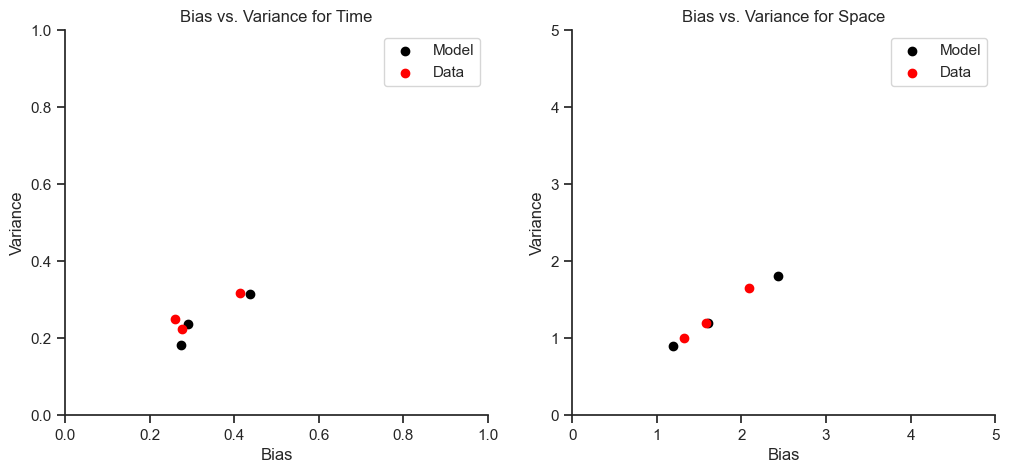

In [9]:
sns.set(style="ticks")
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.despine()
vis.plotBiasVersusVariance(axs, 0, biasTimeModel, varTimeModel, biasTimeData, varTimeData, [0, 1], [0, 1], 'Time', 'black', 'red')
vis.plotBiasVersusVariance(axs, 1, biasSpaceModel, varSpaceModel, biasSpaceData, varSpaceData, [0, 5], [0, 5], 'Space', 'black', 'red')

## Plot Data Across Conditions

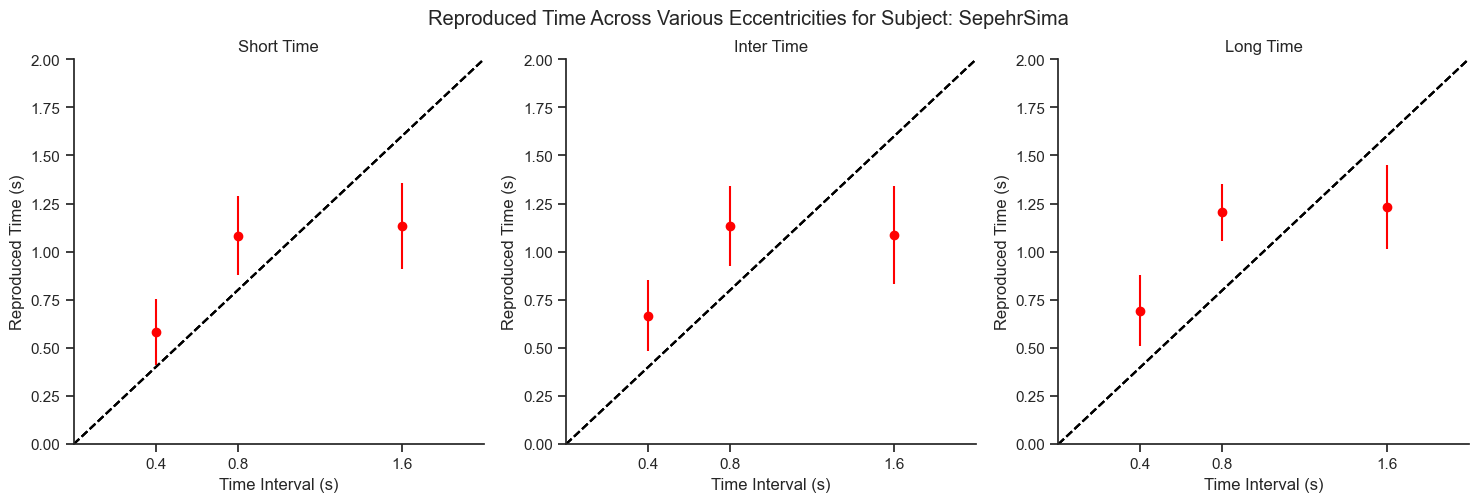

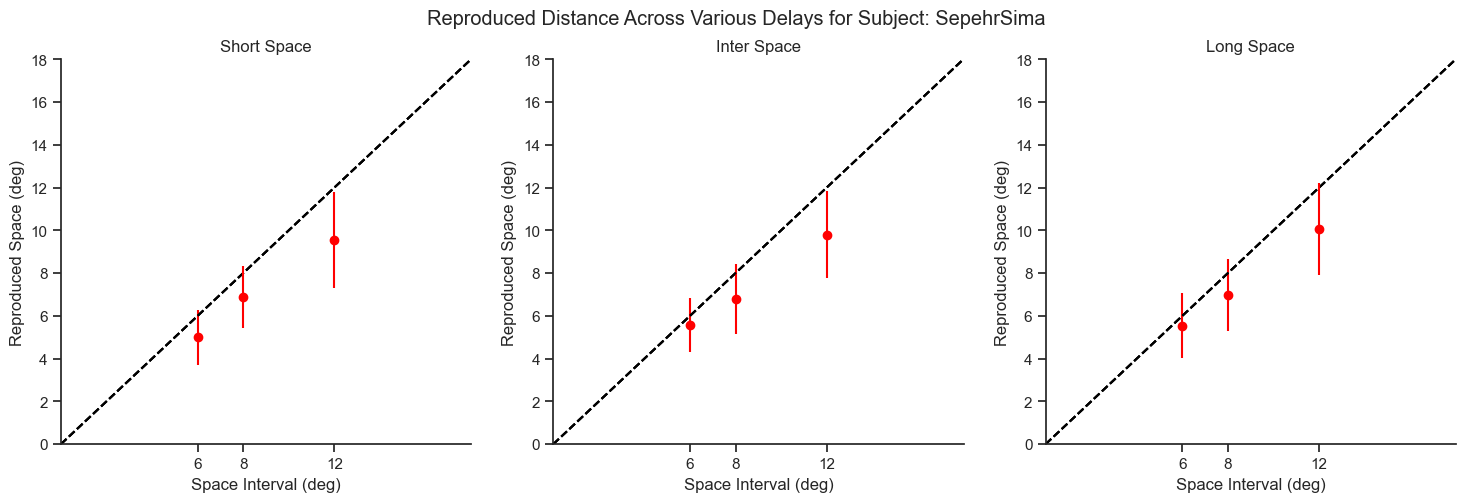

In [82]:
sns.set(style="ticks")
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sns.despine()
vis.plotDataAcrossConds(axs, intervalTypes, timeInts, allCondTime, 'Time', 's', [0, 2], [0, 2], 'red')
fig.suptitle(f'Reproduced Time Across Various Eccentricities for Subject: {subjectName}')
fig.set_size_inches(18, 5)
plt.savefig(os.path.join(subjectFigPath, subjectName+'_scatter_eccentDivided.png'), dpi=300)

sns.set(style="ticks")
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sns.despine()
vis.plotDataAcrossConds(axs, intervalTypes, distInts, allCondSpace, 'Space', 'deg', [0, 18], [0, 18], 'red')
fig.suptitle(f'Reproduced Distance Across Various Delays for Subject: {subjectName}')
fig.set_size_inches(18, 5)
plt.savefig(os.path.join(subjectFigPath, subjectName+'_scatter_delayDivided.png'), dpi=300)

# Model Stats

In [24]:
timuMuR2_BLS  = r2_score(muTime, muTimeTrans_BLS)
timuMuR2_MAP  = r2_score(muTime, muTimeTrans_MAP) 
timuMuR2_MLE  = r2_score(muTime, muTimeTrans_MLE) 

spaceMuR2_BLS = r2_score(muSpace, muSpaceTrans_BLS)
spaceMuR2_MAP = r2_score(muSpace, muSpaceTrans_MAP)
spaceMuR2_MLE = r2_score(muSpace, muSpaceTrans_MLE)

AICTime_BLS = AICMet(timeNLL_BLS, len(initialValues))
AICTime_MAP = AICMet(timeNLL_MAP, len(initialValues))
AICTime_MLE = AICMet(timeNLL_MLE, len(initialValues))

BICTime_BLS = BICMet(timeNLL_BLS, len(initialValues), len(tPvec))
BICTime_MAP = BICMet(timeNLL_MAP, len(initialValues), len(tPvec))
BICTime_MLE = BICMet(timeNLL_MLE, len(initialValues), len(tPvec))

AICSpace_BLS = AICMet(spaceNLL_BLS, len(initialValues))
AICSpace_MAP = AICMet(spaceNLL_MAP, len(initialValues))
AICSpace_MLE = AICMet(spaceNLL_MLE, len(initialValues))

BICSpace_BLS = BICMet(spaceNLL_BLS, len(initialValues), len(dPvec))
BICSpace_MAP = BICMet(spaceNLL_MAP, len(initialValues), len(dPvec))
BICSpace_MLE = BICMet(spaceNLL_MLE, len(initialValues), len(dPvec))

(timuMuR2_BLS, timuMuR2_MAP, timuMuR2_MLE), (spaceMuR2_BLS, spaceMuR2_MAP, spaceMuR2_MLE), (AICTime_BLS, AICTime_MAP, AICTime_MLE), (AICSpace_BLS, AICSpace_MAP, AICSpace_MLE)

((0.9964954537735234, 0.7890776414014811, -0.06612255509129761),
 (0.9909284454480243, 0.6494968268616461, 0.9708837209326177),
 (203.56730813707406, 358.66553881467814, 449.36319719674543),
 (1675.3784872152578, 1675.5710915492173, 1676.2175541220874))

## Plot Simulation Data Over Real Data

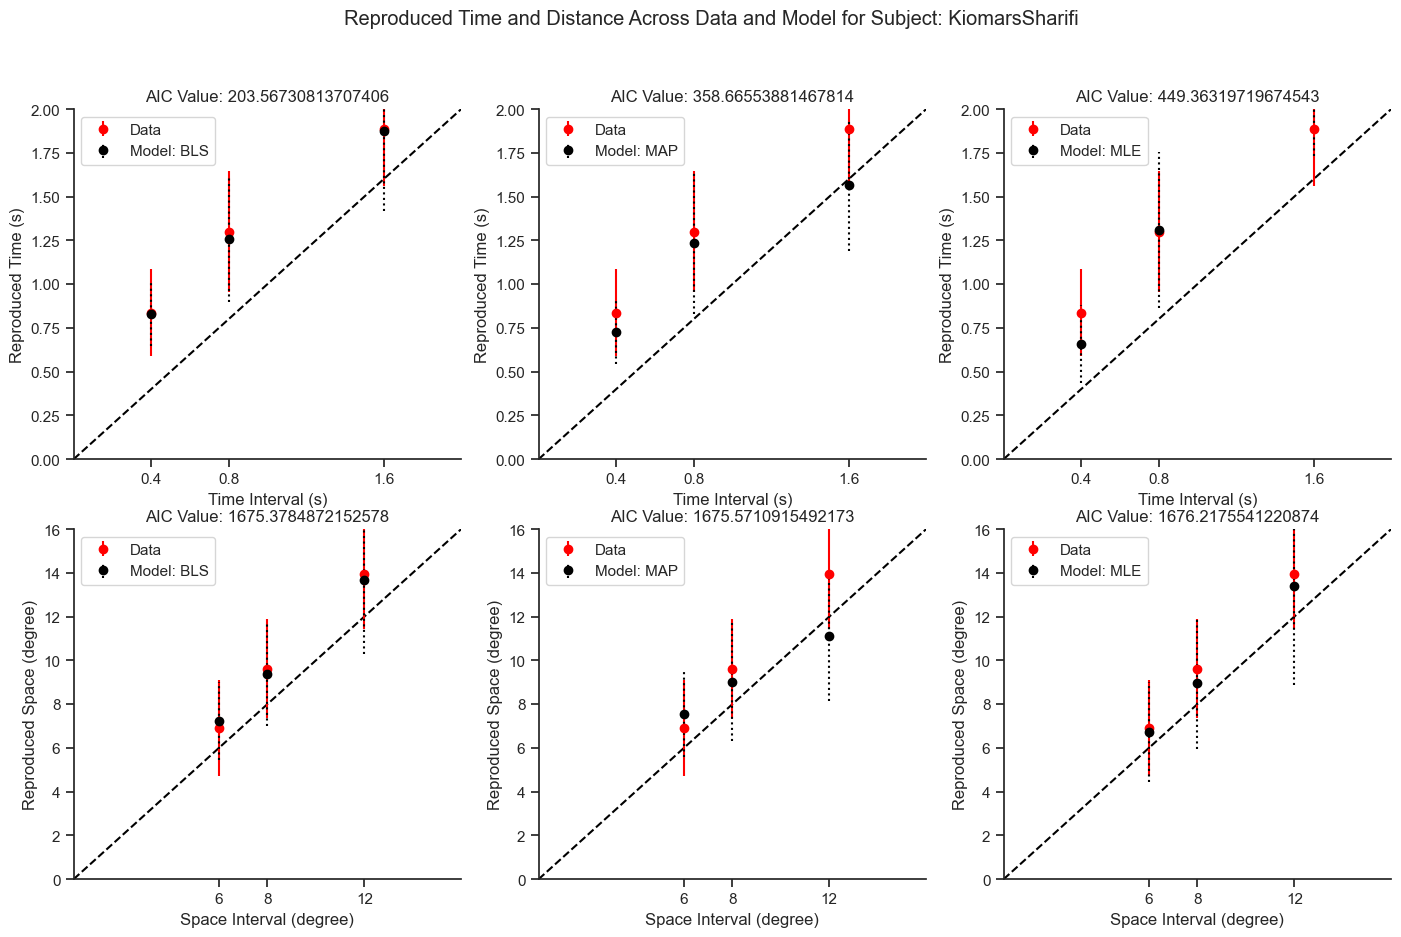

In [25]:
sns.set(style="ticks")
fig, axs = plt.subplots(2, 3, figsize=(17, 10))
sns.despine()
                  
vis.plotModelOverData(axs, 0, 0, timeInts, muTime, siTime, muTimeTrans_BLS, siTimeTrans_BLS, 'Time', 's', [0, 2], [0, 2], 'red', 'black', 'BLS', AICTime_BLS)
vis.plotModelOverData(axs, 0, 1, timeInts, muTime, siTime, muTimeTrans_MAP, siTimeTrans_MAP, 'Time', 's', [0, 2], [0, 2], 'red', 'black', 'MAP', AICTime_MAP)
vis.plotModelOverData(axs, 0, 2, timeInts, muTime, siTime, muTimeTrans_MLE, siTimeTrans_MLE, 'Time', 's', [0, 2], [0, 2], 'red', 'black', 'MLE', AICTime_MLE)
vis.plotModelOverData(axs, 1, 0, distInts, muSpace, siSpace, muSpaceTrans_BLS, siSpaceTrans_BLS, 'Space', 'degree', [0, 16], [0, 16], 'red', 'black', 'BLS', AICSpace_BLS)
vis.plotModelOverData(axs, 1, 1, distInts, muSpace, siSpace, muSpaceTrans_MAP, siSpaceTrans_MAP, 'Space', 'degree', [0, 16], [0, 16], 'red', 'black', 'MAP', AICSpace_MAP)
vis.plotModelOverData(axs, 1, 2, distInts, muSpace, siSpace, muSpaceTrans_MLE, siSpaceTrans_MLE, 'Space', 'degree', [0, 16], [0, 16], 'red', 'black', 'MLE', AICSpace_MLE)
fig.suptitle(f'Reproduced Time and Distance Across Data and Model for Subject: {subjectName}')
fig.set_size_inches(17, 10)
# plt.savefig(os.path.join(subjectFigPath, subjectName+'_scatter_SimOverDataModified.png'), dpi=300)

In [27]:
facSpace_BLS

1.1705801611087252

## Plot Simulation SD Data Over Real SD Data

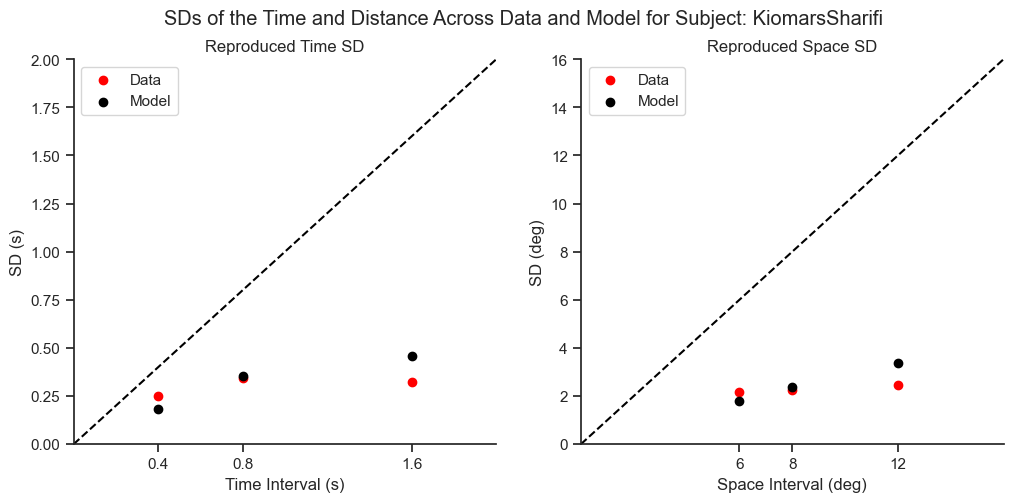

In [28]:
sns.set(style="ticks")
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.despine()

vis.plotSdModelOverData(axs, 0, timeInts, siTime, siTimeTrans_BLS, 'Time', 's', [0, 2], [0, 2], 'red', 'black')
vis.plotSdModelOverData(axs, 1, distInts, siSpace, siSpaceTrans_BLS, 'Space', 'deg', [0, 16], [0, 16], 'red', 'black')
fig.suptitle(f'SDs of the Time and Distance Across Data and Model for Subject: {subjectName}')
fig.set_size_inches(12, 5)
# plt.savefig(os.path.join(subjectFigPath, subjectName+'_scatter_SDs.png'), dpi=300)

# Save Parameters

In [66]:
subInfoInput.loc[subInfoInput['name'] == subjectName,'AIC_BLS_Space'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'AIC_MAP_Space'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'AIC_MLE_Space'] = float('nan')

subInfoInput.loc[subInfoInput['name'] == subjectName,'AIC_BLS_Time'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'AIC_MAP_Time'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'AIC_MLE_Time'] = float('nan')

subInfoInput.loc[subInfoInput['name'] == subjectName,'BIC_BLS_Space'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'BIC_MAP_Space'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'BIC_MLE_Space'] = float('nan')

subInfoInput.loc[subInfoInput['name'] == subjectName,'BIC_BLS_Time'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'BIC_MAP_Time'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'BIC_MLE_Time'] = float('nan')

subInfoInput.loc[subInfoInput['name'] == subjectName,'timeWm_BLS'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'timeWm_MAP'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'timeWm_MLE'] = float('nan')

subInfoInput.loc[subInfoInput['name'] == subjectName,'spaceWm_BLS'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'spaceWm_MAP'] = float('nan')
subInfoInput.loc[subInfoInput['name'] == subjectName,'spaceWm_MLE'] = float('nan')


for estim in estimType:
    if estim == 'BLS':
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'timeWm_BLS'] = w_mTime_BLS
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'timeWp_BLS'] = w_pTime_BLS

        subInfoInput.loc[subInfoInput['name'] == subjectName, 'spaceWm_BLS'] = w_mSpace_BLS
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'spaceWp_BLS'] = w_pSpace_BLS
        
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'AIC_BLS_Time'] = AICTime_BLS
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'BIC_BLS_Time'] = BICTime_BLS

        subInfoInput.loc[subInfoInput['name'] == subjectName, 'AIC_BLS_Space'] = AICSpace_BLS
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'BIC_BLS_Space'] = BICSpace_BLS
    elif estim == 'MAP':
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'timeWm_MAP'] = w_mTime_MAP
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'timeWp_MAP'] = w_pTime_MAP

        subInfoInput.loc[subInfoInput['name'] == subjectName, 'spaceWm_MAP'] = w_mSpace_MAP
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'spaceWp_MAP'] = w_pSpace_MAP

        subInfoInput.loc[subInfoInput['name'] == subjectName, 'AIC_MAP_Time'] = AICTime_MAP
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'BIC_MAP_Time'] = BICTime_MAP

        subInfoInput.loc[subInfoInput['name'] == subjectName, 'AIC_MAP_Space'] = AICSpace_MAP
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'BIC_MAP_Space'] = BICSpace_MAP
    else:
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'timeWm_MLE'] = w_mTime_MLE
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'timeWp_MLE'] = w_pTime_MLE

        subInfoInput.loc[subInfoInput['name'] == subjectName, 'spaceWm_MLE'] = w_mSpace_MLE
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'spaceWp_MLE'] = w_pSpace_MLE

        subInfoInput.loc[subInfoInput['name'] == subjectName, 'AIC_MLE_Time'] = AICTime_MLE
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'BIC_MLE_Time'] = BICTime_MLE

        subInfoInput.loc[subInfoInput['name'] == subjectName, 'AIC_MLE_Space'] = AICSpace_MLE
        subInfoInput.loc[subInfoInput['name'] == subjectName, 'BIC_MLE_Space'] = BICSpace_MLE
        
subInfoInput.to_csv(os.path.join(subInfoPath, 'subInfo.csv'), index=False)


In [67]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
subInfoInput

,name,ID,age,gender,handedness,firstBlocks,lineLoc,lineOr,AIC_BLS_Space,AIC_MAP_Space,AIC_MLE_Space,AIC_BLS_Time,AIC_MAP_Time,AIC_MLE_Time,BIC_BLS_Space,BIC_MAP_Space,BIC_MLE_Space,BIC_BLS_Time,BIC_MAP_Time,BIC_MLE_Time,timeWm_BLS,timeWm_MAP,timeWm_MLE,spaceWm_BLS,spaceWm_MAP,spaceWm_MLE,timeWp_BLS,spaceWp_BLS,timeWp_MAP,spaceWp_MAP,timeWp_MLE,spaceWp_MLE
0,SepehrSima,1,23,M,R,time,right,up,1723.961544,1697.692723,1636.517675,62.289494,431.770355,259.744163,1731.949467,1705.680646,1644.505598,70.221787,439.702648,267.676457,0.337600,0.202483,0.002862,0.028952,0.157583,0.252126,0.233586,0.249585,0.489834,0.233538,0.560359,0.001332
1,MehdiSanayei,2,40,M,R,space,left,up,1787.866281,1779.493514,1779.176803,65.202297,180.000110,280.268592,1795.893712,1787.520944,1787.204233,73.229727,188.027541,288.296023,0.250867,0.373395,0.196491,0.025980,0.001957,0.027377,0.270269,0.255659,0.239316,0.254041,0.363905,0.251863
2,KiomarsSharifi,3,28,M,R,time,right,up,1781.222723,1783.372020,1783.942525,542.988522,772.543846,586.284588,1789.006011,1791.155308,1791.725813,550.868865,780.424189,594.164930,0.356301,0.137908,0.002868,0.039046,0.018793,0.002258,0.466312,0.333881,0.824103,0.337040,0.864551,0.337774
3,MobinAdli,4,23,M,R,space,right,up,1375.905153,1360.956861,1344.631076,257.615863,503.030210,576.021392,1383.416637,1368.468345,1352.142560,265.158745,510.573093,583.564274,0.428116,0.361277,0.227883,0.059548,0.163968,0.271078,0.356510,0.256364,0.619502,0.241312,0.680510,0.042972
4,AliHajian,5,21,M,L,time,left,down,1596.619898,1574.046984,1517.739097,216.954559,273.021770,303.705409,1604.577670,1582.004755,1525.696868,224.927463,280.994674,311.678313,0.188463,0.173148,0.102428,0.026013,0.133449,0.224170,0.350739,0.217332,0.394053,0.203719,0.422924,0.007077
5,MiladYekani,6,35,M,R,space,left,down,1787.226357,1793.712899,1797.386780,93.702631,306.937211,404.889271,1795.153516,1801.640058,1805.313939,101.598701,314.833281,412.785341,0.305398,0.330811,0.210539,0.060273,0.049484,0.002367,0.267818,0.283248,0.371449,0.288161,0.444723,0.293280
6,MobinaKhosravi,7,21,F,R,time,right,down,1729.341235,1704.530448,1621.724807,208.940289,356.259321,407.733255,1737.353942,1712.543154,1629.737513,216.943119,364.262151,415.736085,0.246272,0.216381,0.138646,0.025980,0.145714,0.246779,0.314735,0.242249,0.407107,0.229117,0.455288,0.040641
7,SoodehMajidpour,8,34,F,R,space,right,down,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,ParisaShadmehr,9,23,F,R,time,left,up,13330.368316,13239.253839,13089.024612,1709.723699,3074.860959,3526.288533,13342.453072,13251.338595,13101.109368,1721.512336,3086.649595,3538.077169,0.305958,0.282021,0.175536,0.030915,0.119735,0.228192,0.330837,0.247858,0.468639,0.235365,0.534869,0.111933


In [28]:
subInfoPath  = r'F:\#2 MS Projects\Ongoing\timePerception\dataInfo\input'
subInfoInput = pd.read_csv(os.path.join(subInfoPath, 'subInfo.csv'))
subInfoInput = subInfoInput.loc[subInfoInput['name'] != 'KiomarsSharifi']
subInfoInput

,name,ID,age,gender,handedness,firstBlocks,lineLoc,lineOr,timeWm,timeWp,spaceWm_BLS,spaceWm_MAP,spaceWp_BLS,spaceWp_MAP,AIC_BLS_Space,AIC_MAP_Space,BIC_BLS_Space,BIC_MAP_Space
0,SepehrSima,1,23,M,R,time,right,up,0.337622,0.233568,0.028976,0.158092,0.249595,0.233362,1723.961549,1697.591458,1731.949471,1705.579381
1,MehdiSanayei,2,40,M,R,space,left,up,0.250867,0.270269,0.025980,0.001957,0.255601,0.254041,1787.866238,1779.493514,1795.893668,1787.520944
2,MobinAdli,4,23,M,R,space,right,up,0.428104,0.356516,0.059535,0.163463,0.256433,0.241339,1375.905159,1361.081314,1383.416643,1368.592798
3,AliHajian,5,21,M,L,time,left,down,0.188449,0.350713,0.026004,0.133796,0.217324,0.203603,1596.619869,1573.967595,1604.577640,1581.925367
4,MiladYekani,6,35,M,R,space,left,down,0.305341,0.267796,0.060327,0.049425,0.283220,0.288136,1787.226358,1793.718985,1795.153517,1801.646143
5,MobinaKhosravi,7,21,F,R,time,right,down,0.246262,0.314827,0.025980,0.146830,0.243093,0.228879,1729.349794,1704.295879,1737.362500,1712.308585
6,SoodehMajidpour,8,34,F,R,space,right,down,NaN,NaN,0.025980,0.129196,0.229740,0.218820,1693.720934,1673.038754,1701.748364,1681.066185
7,ParisaShadmehr,9,23,F,R,time,left,up,0.360200,0.488303,0.053203,0.116587,0.252453,0.244964,1737.312509,1730.046645,1745.290431,1738.024568


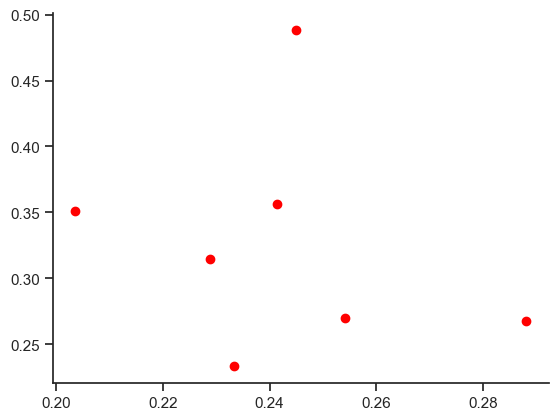

In [17]:
sns.set(style="ticks")
# fig, axs = plt.subplots(1, 2, figsize=(12, 5))


# sns.lineplot(x=np.linspace(xLim[0], xLim[1], xLim[1]), y=np.linspace(yLim[0], yLim[1], yLim[1]), linestyle="dashed", color='black', ax=axs[axn])
# plt.scatter(x=subInfoInput['spaceWm_MAP'], y=subInfoInput['timeWm'], color='red')
plt.scatter(x=subInfoInput['spaceWp_MAP'], y=subInfoInput['timeWp'], color='red')
sns.despine()
# axs[axn].set_xlabel(f'{type} Interval ({unit})')
# axs[axn].set_ylabel(f'SD ({unit})')
# axs[axn].set_title(f'Reproduced {type} SD')
# axs[axn].set_xticks(Ints)
# axs[axn].set_xlim(xLim)
# axs[axn].set_ylim(yLim)
# axs[axn].legend([dat, mod], ['Data', 'Model'])

In [20]:
subInfoInput = subInfoInput.loc[subInfoInput['name'] != 'SoodehMajidpour']

r, p = pearsonr(subInfoInput['spaceWm_MAP'], subInfoInput['timeWm'])
r, p

(0.31691118535690166, 0.4885994980425767)